<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/bayes/schools8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we fit a hierarchical Bayesian model to the "8 schools" dataset.
See also https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

In [2]:
%matplotlib inline
import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
!pip install pymc3==3.8
import pymc3 as pm
pm.__version__
import theano.tensor as tt
import theano

!pip install arviz
import arviz as az

     |████████████████████████████████| 911kB 2.8MB/s 
     |████████████████████████████████| 1.5MB 13.8MB/s 
     |████████████████████████████████| 4.1MB 20.8MB/s 
     |████████████████████████████████| 327kB 28.8MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


8.75
7.5


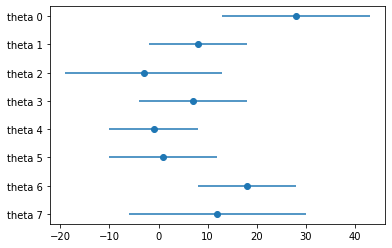

In [22]:
# https://github.com/probml/pyprobml/blob/master/scripts/schools8_pymc3.py

# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
print(np.mean(y))
print(np.median(y))

names=[]; 
for t in range(8):
    names.append('theta {}'.format(t)); 

# Plot raw data
fig, ax = plt.subplots()
y_pos = np.arange(8)
ax.errorbar(y,y_pos, xerr=sigma, fmt='o')
ax.set_yticks(y_pos)
ax.set_yticklabels(names)
ax.invert_yaxis()  # labels read top-to-bottom
plt.show()

In [6]:
# Centered model
with pm.Model() as Centered_eight:
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=5)
    alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=J)
    obs = pm.Normal('obs', mu=alpha, sigma=sigma, observed=y)
    log_sigma_alpha = pm.Deterministic('log_sigma_alpha', tt.log(sigma_alpha))
    
np.random.seed(0)
with Centered_eight:
    trace_centered = pm.sample(10000, chains=4)
    
pm.summary(trace_centered).round(2)
# PyMC3 gives multiple warnings about  divergences
# Also, see r_hat ~ 1.01, ESS << nchains*1000, especially for sigma_alpha
# We can solve these problems below by using a non-centered parameterization.
# In practice, for this model, the results are very similar.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [alpha, sigma_alpha, mu_alpha]
Sampling chain 3, 157 divergences: 100%|██████████| 10500/10500 [00:15<00:00, 660.66it/s]
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
There were 197 divergences after tuning. Increase `target_accept` or reparameterize.
There were 372 divergences after tuning. Increase `target_accept` or reparameterize.
There were 595 divergences after tuning. Increase `target_accept` or reparameterize.
There were 752 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,4.38,3.39,-2.16,10.40,0.07,0.05,2550.0,2550.0,2565.0,2486.0,1.00
alpha[0],6.41,5.78,-3.99,17.47,0.09,0.06,4178.0,4178.0,3511.0,3751.0,1.00
alpha[1],5.02,4.91,-4.14,14.28,0.07,0.05,4643.0,4643.0,4229.0,4345.0,1.00
alpha[2],3.88,5.46,-6.73,13.76,0.07,0.05,5705.0,5705.0,4898.0,10517.0,1.00
alpha[3],4.76,4.97,-4.53,14.15,0.06,0.05,5788.0,5788.0,5229.0,15616.0,1.00
alpha[4],3.51,4.82,-5.53,12.59,0.07,0.05,4813.0,4813.0,4422.0,5995.0,1.00
alpha[5],3.94,5.02,-5.72,13.27,0.07,0.05,5001.0,5001.0,4573.0,8022.0,1.00
alpha[6],6.53,5.31,-2.65,17.25,0.08,0.06,3958.0,3958.0,3452.0,1117.0,1.00
alpha[7],4.89,5.57,-5.51,15.64,0.07,0.05,6505.0,6505.0,5318.0,15296.0,1.00
sigma_alpha,4.05,3.10,0.58,9.52,0.07,0.05,2017.0,2017.0,815.0,419.0,1.01


In [7]:
# Display the total number and percentage of divergent chains
diverging = trace_centered['diverging']
print('Number of Divergent Chains: {}'.format(diverging.nonzero()[0].size))
diverging_pct = diverging.nonzero()[0].size / len(trace_centered) * 100
print('Percentage of Divergent Chains: {:.1f}'.format(diverging_pct))

Number of Divergent Chains: 752
Percentage of Divergent Chains: 7.5


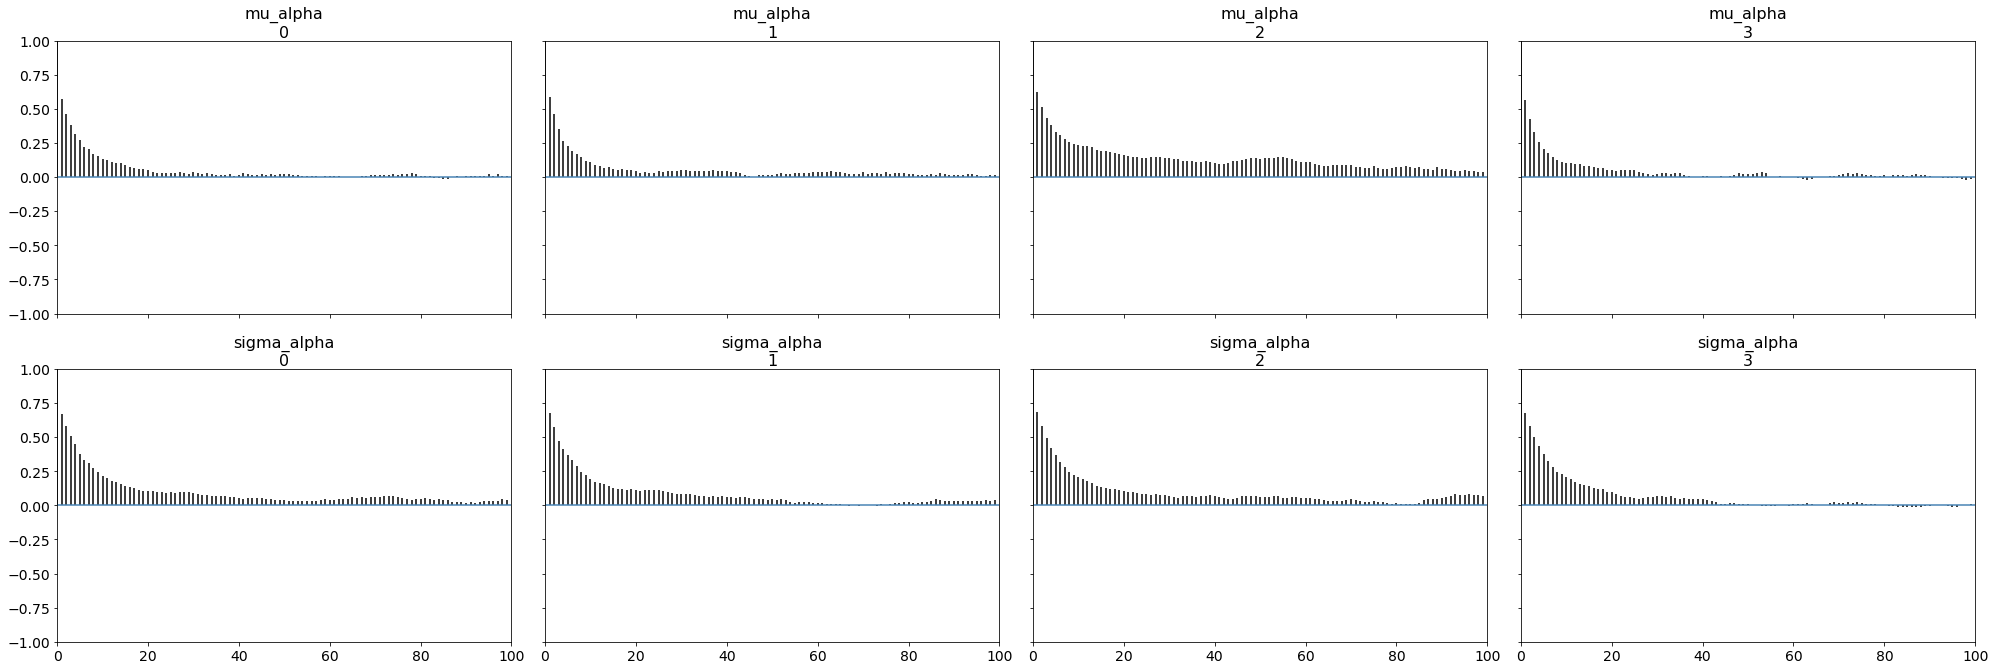

In [8]:
# We can see somewhat high auto correlation of the samples
az.plot_autocorr(trace_centered, var_names=['mu_alpha', 'sigma_alpha']);

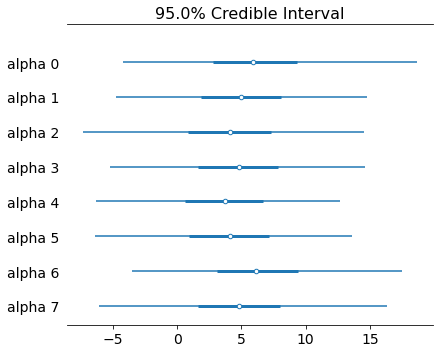

In [9]:

az.plot_forest(trace_centered, var_names="alpha", 
               credible_interval=0.95, combined=True);

In [11]:
# Non-centered parameterization

with pm.Model() as NonCentered_eight:
    mu_alpha = pm.Normal('mu_alpha', mu=0, sigma=5)
    sigma_alpha = pm.HalfCauchy('sigma_alpha', beta=5)
    alpha_offset = pm.Normal('alpha_offset', mu=0, sigma=1, shape=J)
    alpha = pm.Deterministic('alpha', mu_alpha + sigma_alpha * alpha_offset)
    #alpha = pm.Normal('alpha', mu=mu_alpha, sigma=sigma_alpha, shape=J)
    obs = pm.Normal('obs', mu=alpha, sigma=sigma, observed=y)
    log_sigma_alpha = pm.Deterministic('log_sigma_alpha', tt.log(sigma_alpha))
    
np.random.seed(0)
with NonCentered_eight:
    trace_noncentered = pm.sample(10000, chains=4)
    
pm.summary(trace_noncentered).round(2)
# Samples look good: r_hat = 1, ESS ~= nchains*1000

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.19.104+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Sequential sampling (4 chains in 1 job)
NUTS: [alpha_offset, sigma_alpha, mu_alpha]
Sampling chain 3, 3 divergences: 100%|██████████| 10500/10500 [00:09<00:00, 1106.74it/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,4.39,3.30,-1.80,10.65,0.02,0.01,39155.0,35768.0,39478.0,23211.0,1.0
alpha_offset[0],0.32,0.99,-1.51,2.21,0.00,0.00,47855.0,18067.0,47787.0,26722.0,1.0
alpha_offset[1],0.10,0.94,-1.67,1.89,0.00,0.00,50056.0,17673.0,50105.0,28230.0,1.0
alpha_offset[2],-0.08,0.96,-1.96,1.67,0.00,0.00,53705.0,16047.0,53602.0,28294.0,1.0
alpha_offset[3],0.06,0.94,-1.72,1.81,0.00,0.00,52013.0,18101.0,52042.0,29063.0,1.0
alpha_offset[4],-0.16,0.92,-1.86,1.64,0.00,0.00,46654.0,18725.0,46660.0,28955.0,1.0
alpha_offset[5],-0.07,0.95,-1.82,1.75,0.00,0.00,48738.0,16644.0,48750.0,27425.0,1.0
alpha_offset[6],0.36,0.96,-1.46,2.17,0.00,0.00,45378.0,19489.0,45415.0,29028.0,1.0
alpha_offset[7],0.08,0.98,-1.79,1.87,0.00,0.00,47547.0,17858.0,47510.0,29225.0,1.0
sigma_alpha,3.62,3.18,0.00,9.33,0.02,0.02,24727.0,20164.0,22515.0,17879.0,1.0


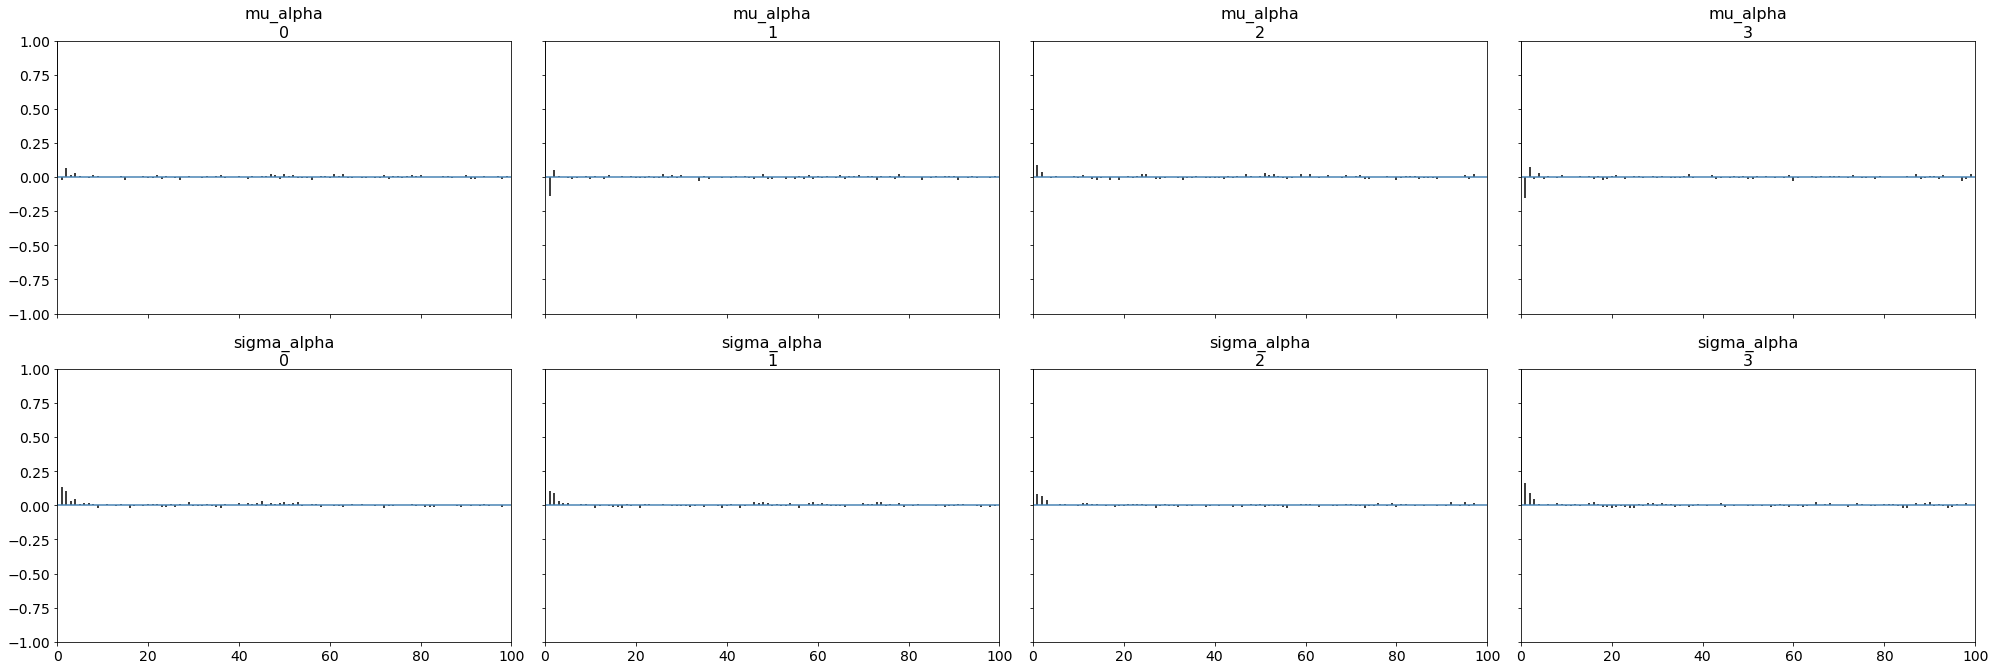

In [12]:
az.plot_autocorr(trace_noncentered, var_names=['mu_alpha', 'sigma_alpha']);

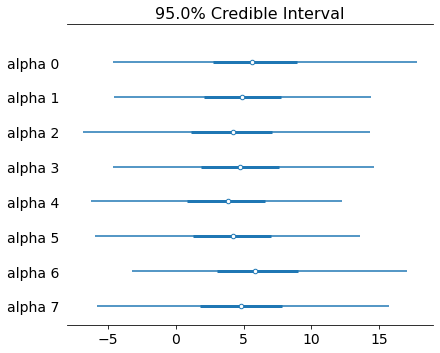

In [13]:
az.plot_forest(trace_noncentered, var_names="alpha",
               combined=True, credible_interval=0.95);

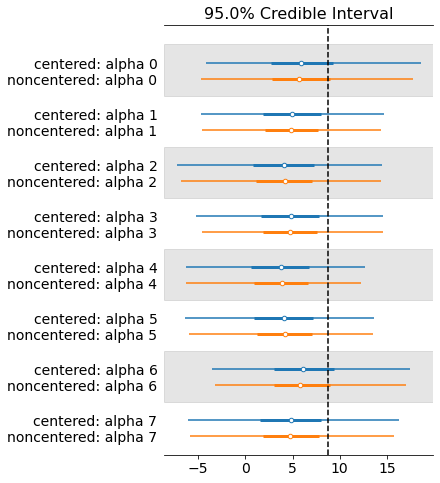

In [23]:
az.plot_forest([trace_centered, trace_noncentered], model_names=['centered', 'noncentered'],
               var_names="alpha",
               combined=True, credible_interval=0.95);
plt.axvline(np.mean(y), color='k', linestyle='--')

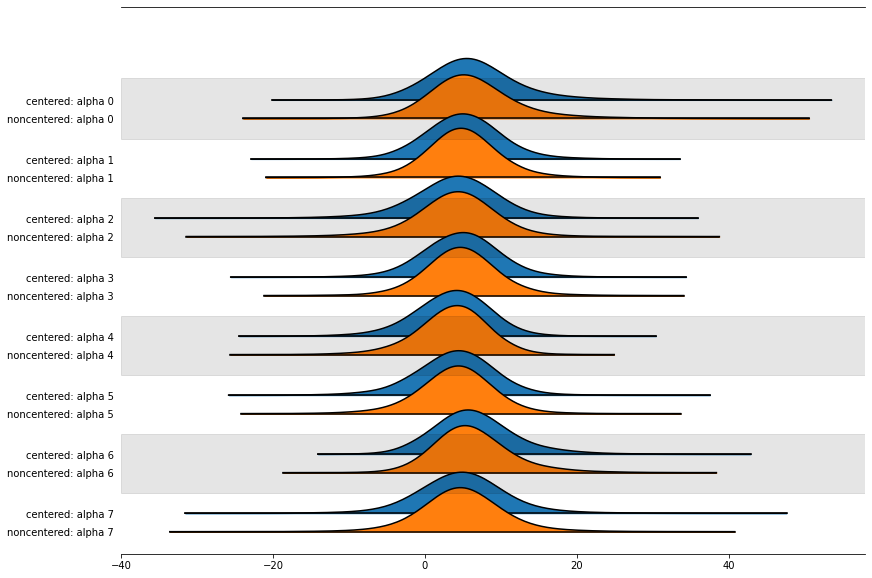

In [20]:
az.plot_forest([trace_centered, trace_noncentered], model_names=['centered', 'noncentered'],
               var_names="alpha", kind='ridgeplot',
               combined=True, credible_interval=0.95);

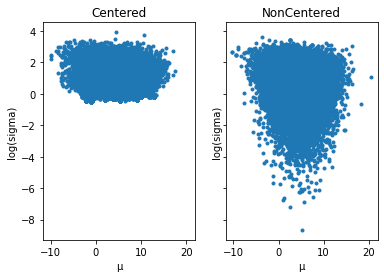

In [24]:
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(trace_centered['mu_alpha'], name='mu_alpha')
y  = pd.Series(trace_centered['log_sigma_alpha'], name='log_sigma_alpha')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='log(sigma)');
#axs[0].axhline(0.01)

x = pd.Series(trace_noncentered['mu_alpha'], name='mu')
y  = pd.Series(trace_noncentered['log_sigma_alpha'], name='log_sigma_alpha')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='log(sigma)');
#axs[1].axhline(0.01)

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

Text(0.5, 0.98, 'noncentered')

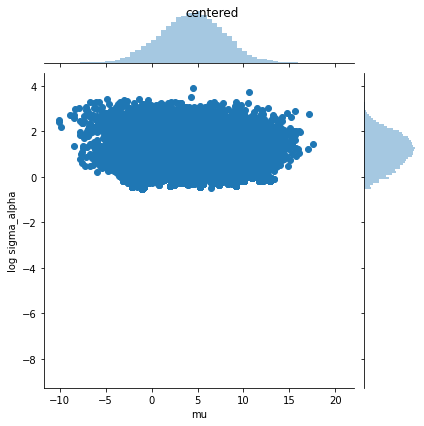

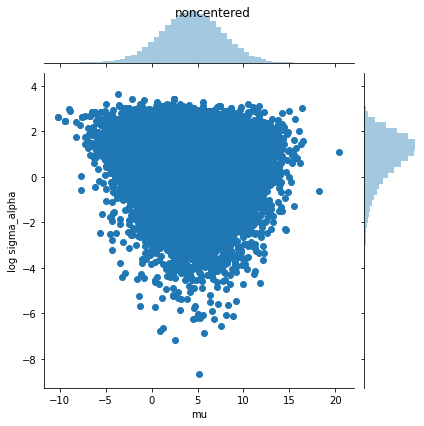

In [16]:
# Plot the "funnel of hell"
# Based on
# https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/GLM_hierarchical_non_centered.ipynb

x = pd.Series(trace_centered['mu_alpha'], name='mu')
y = pd.Series(trace_centered['log_sigma_alpha'], name='log sigma_alpha')
sns.jointplot(x, y, xlim=xlim, ylim=ylim);
plt.suptitle('centered')

x = pd.Series(trace_noncentered['mu_alpha'], name='mu')
y = pd.Series(trace_noncentered['log_sigma_alpha'], name='log sigma_alpha')
sns.jointplot(x, y, xlim=xlim, ylim=ylim);
plt.suptitle('noncentered')

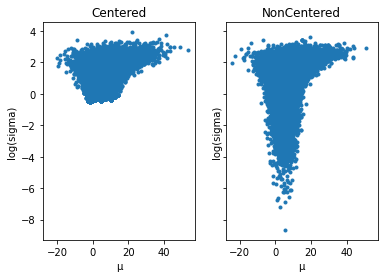

In [17]:
group = 0
fig, axs = plt.subplots(ncols=2, sharex=True, sharey=True)
x = pd.Series(trace_centered['alpha'][:, group], name=f'alpha {group}')
y  = pd.Series(trace_centered['log_sigma_alpha'], name='log_sigma_alpha')
axs[0].plot(x, y, '.');
axs[0].set(title='Centered', xlabel='µ', ylabel='log(sigma)');

x = pd.Series(trace_noncentered['alpha'][:,group], name=f'alpha {group}')
y  = pd.Series(trace_noncentered['log_sigma_alpha'], name='log_sigma_alpha')
axs[1].plot(x, y, '.');
axs[1].set(title='NonCentered', xlabel='µ', ylabel='log(sigma)');

xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()